In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, 
    matthews_corrcoef, 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score, 
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay
)

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

import scienceplots
plt.style.use(['science', 'no-latex'])

## Load Dataset

In [2]:
df_train = pd.read_parquet("../dataset/merged/train.parquet")
df_test = pd.read_parquet("../dataset/merged/test.parquet")

In [4]:
# cols_exclude_sel = [x for x in df_train.columns.tolist() if "_sum" in x]
# cols_non_features = ["ts", "zone_id", "country", "target", ""]
# cols_exclude = cols_exclude_sel + cols_non_features

# X_train, y_train = df_train.drop(columns=cols_exclude, errors="ignore"), df_train["target"]
# X_test, y_test = df_test.drop(columns=cols_exclude, errors="ignore"), df_test["target"]

In [5]:
cols_inc = ["distance", "po4_mean", "pbo_mean", "slope_mean", "aspect_mean"]

X_train, y_train = df_train[cols_inc], df_train["target"]
X_test, y_test = df_test[cols_inc], df_test["target"]

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2531340 entries, 2089960 to 2278645
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   distance     float64
 1   po4_mean     float64
 2   pbo_mean     float64
 3   slope_mean   float64
 4   aspect_mean  float64
dtypes: float64(5)
memory usage: 115.9 MB


In [7]:
n_neg = y_train[y_train == 0].shape[0]
n_pos = y_train[y_train == 1].shape[0]

n_neg/n_pos

82.52327845052298

## Cross Validation

In [77]:
def cross_val_custom(model, X, y):
    print(f"Training model: {model}")
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for fold_i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print(f"Training fold {fold_i + 1}")

        # split data
        X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
        y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]

        if model == "decision-tree":
            clf = DecisionTreeClassifier(random_state=42, max_depth=100, class_weight="balanced")
        elif model == "random-forest":
            clf = RandomForestClassifier(random_state=42, n_jobs=8, max_depth=100, n_estimators=100, class_weight="balanced")
        elif model == "catboost":
            clf = CatBoostClassifier(random_seed=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos, verbose=0)
        elif model == "xgboost":
            clf = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos)

        # fit model
        st_train = time.time()
        clf.fit(X_cv_train, y_cv_train)
        dt_train = time.time() - st_train

        # predict
        st_test = time.time()
        y_pred = clf.predict(X_cv_test)
        dt_test = time.time() - st_test

        # eval
        yield {
            "model": model,
            "fold": fold_i + 1,

            "accuracy": accuracy_score(y_cv_test, y_pred),
            "precision": precision_score(y_cv_test, y_pred),
            "recall": recall_score(y_cv_test, y_pred),
            "f1": f1_score(y_cv_test, y_pred),
            "mcc": matthews_corrcoef(y_cv_test, y_pred),
            "roc_auc": roc_auc_score(y_cv_test, y_pred),
            "ap": average_precision_score(y_cv_test, y_pred),
            
            "training_duration": dt_train,
            "inference_duration": dt_test,
        }

In [78]:
scores = [
    *cross_val_custom("xgboost", X_train, y_train),
    *cross_val_custom("catboost", X_train, y_train),
    *cross_val_custom("decision-tree", X_train, y_train),
    *cross_val_custom("random-forest", X_train, y_train),
]

df_scores = pd.DataFrame(scores)
df_scores.to_csv("cross-val-undersampling.csv")
df_scores.head()

Training model: xgboost
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Training model: catboost
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Training model: decision-tree
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Training model: random-forest
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10


,model,fold,accuracy,precision,recall,f1,mcc,roc_auc,ap,training_duration,inference_duration
0,xgboost,1,0.998708,0.997423,1.0,0.998710,0.997420,0.998708,0.997423,0.573012,0.006827
1,xgboost,2,0.998708,0.997423,1.0,0.998710,0.997420,0.998708,0.997423,1.077046,0.012677
2,xgboost,3,0.997786,0.995591,1.0,0.997791,0.995581,0.997785,0.995591,0.571794,0.006602
3,xgboost,4,0.997970,0.995957,1.0,0.997975,0.995948,0.997970,0.995957,0.587591,0.008029
4,xgboost,5,0.997970,0.995956,1.0,0.997974,0.995948,0.997970,0.995956,0.680932,0.010453


In [79]:
df_scores["model_name"] = df_scores["model"].replace({"xgboost": "XGBoost", "catboost": "CatBoost", "decision-tree": "Decision Tree", "random-forest": "Random Forest"})

/tmp/ipykernel_20990/358753394.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


[Text(0, 0, 'XGBoost'),
 Text(1, 0, 'CatBoost'),
 Text(2, 0, 'Decision Tree'),
 Text(3, 0, 'Random Forest')]

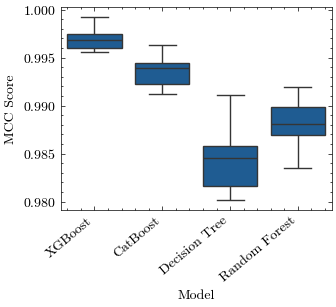

In [80]:
fig, ax = plt.subplots()
sns.boxplot(data=df_scores, x="model_name", y="mcc", ax=ax)
ax.set_ylabel("MCC Score")
ax.set_xlabel("Model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

## Training and Evaluation

In [9]:
# best_params = yaml.safe_load(open("../dataset/models/best_params_xgboost.yml", "r"))
# clf = DecisionTreeClassifier(random_state=42, max_depth=100, class_weight="balanced")
# clf = RandomForestClassifier(random_state=42, n_jobs=8, max_depth=100, n_estimators=100, class_weight="balanced")
# clf = CatBoostClassifier(random_seed=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos, verbose=0)
clf = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos)

st = time.time()
clf.fit(X_train, y_train)
dt = time.time() - st

# joblib.dump(clf, "../dataset/models/random_forest.joblib")
print("Time:", np.round(dt, 5))

Time: 10.86719


In [10]:
st = time.time()
y_pred = clf.predict(X_test)
dt = time.time() - st

print("Time:", np.round(dt, 5))
print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 5))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 5))
print("Precision:", np.round(precision_score(y_test, y_pred), 5))
print("Recall:", np.round(recall_score(y_test, y_pred), 5))
print("F1:", np.round(f1_score(y_test, y_pred), 5))

print(classification_report(y_test, y_pred))

Time: 0.24732
MCC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    625258
           1       1.00      1.00      1.00      7577

    accuracy                           1.00    632835
   macro avg       1.00      1.00      1.00    632835
weighted avg       1.00      1.00      1.00    632835



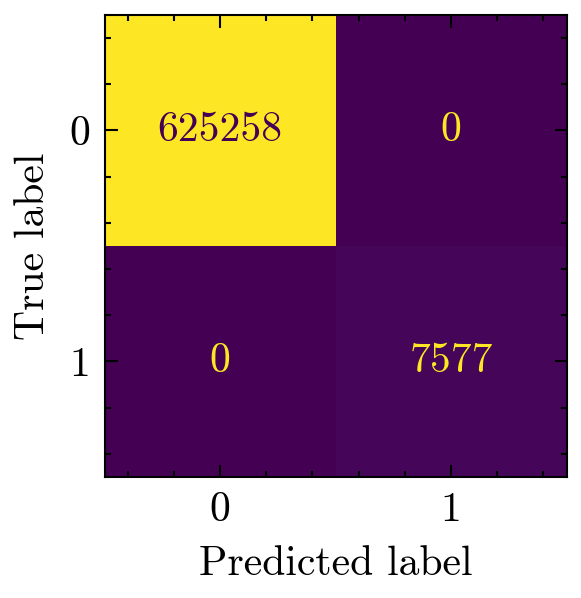

In [11]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

In [9]:
# decision tree
# pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot.barh()

# random forest
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
# pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot.barh(xerr=std)

## Feature Importance SHAP

In [12]:
import shap
shap.initjs()

/home/fahmi/research/thesis-tree/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
rng = np.random.default_rng(seed=121)
idx = rng.choice(np.arange(X_test.shape[0]), 1000, replace=False)

X_shap = X_test.iloc[idx, :]
y_shap = y_test.iloc[idx]

np.where(y_shap == 1)

(array([373, 386, 413, 427, 445, 486, 700, 709, 750, 779, 789, 812, 878,
        919, 922, 926, 959]),)

In [14]:
# decision tree
# explainer = shap.KernelExplainer(clf.predict_proba, X_train.sample(n=150))
# ensemble
explainer = shap.TreeExplainer(clf)

shap_values = explainer(X_shap)

In [15]:
# correct SHAP shape
if len(shap_values.values.shape) == 3:
    # decision tree, random forest
    norm_shap_values = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
else:
    # xgboost, catboost
    norm_shap_values = np.mean(np.abs(shap_values.values), axis=0)

shap_abs_mean = pd.Series(norm_shap_values, index=[x.replace("_mean", "").replace("bathy", "depth") for x in shap_values.feature_names]).sort_values(ascending=False)
# shap_abs_mean.to_csv("shap-xgboost.csv")
shap_abs_mean.round(5)

distance    5.99279
pbo         5.37848
slope       2.52000
aspect      2.17176
po4         0.83532
dtype: float32

In [16]:
xgb_importance = pd.Series(clf.get_booster().get_score(importance_type="gain"))
xgb_importance.index = [x.replace("_mean", "") for x in xgb_importance.index]
xgb_importance

distance    7534.037109
po4          662.052795
pbo          669.132385
slope        595.689514
aspect       536.824829
dtype: float64

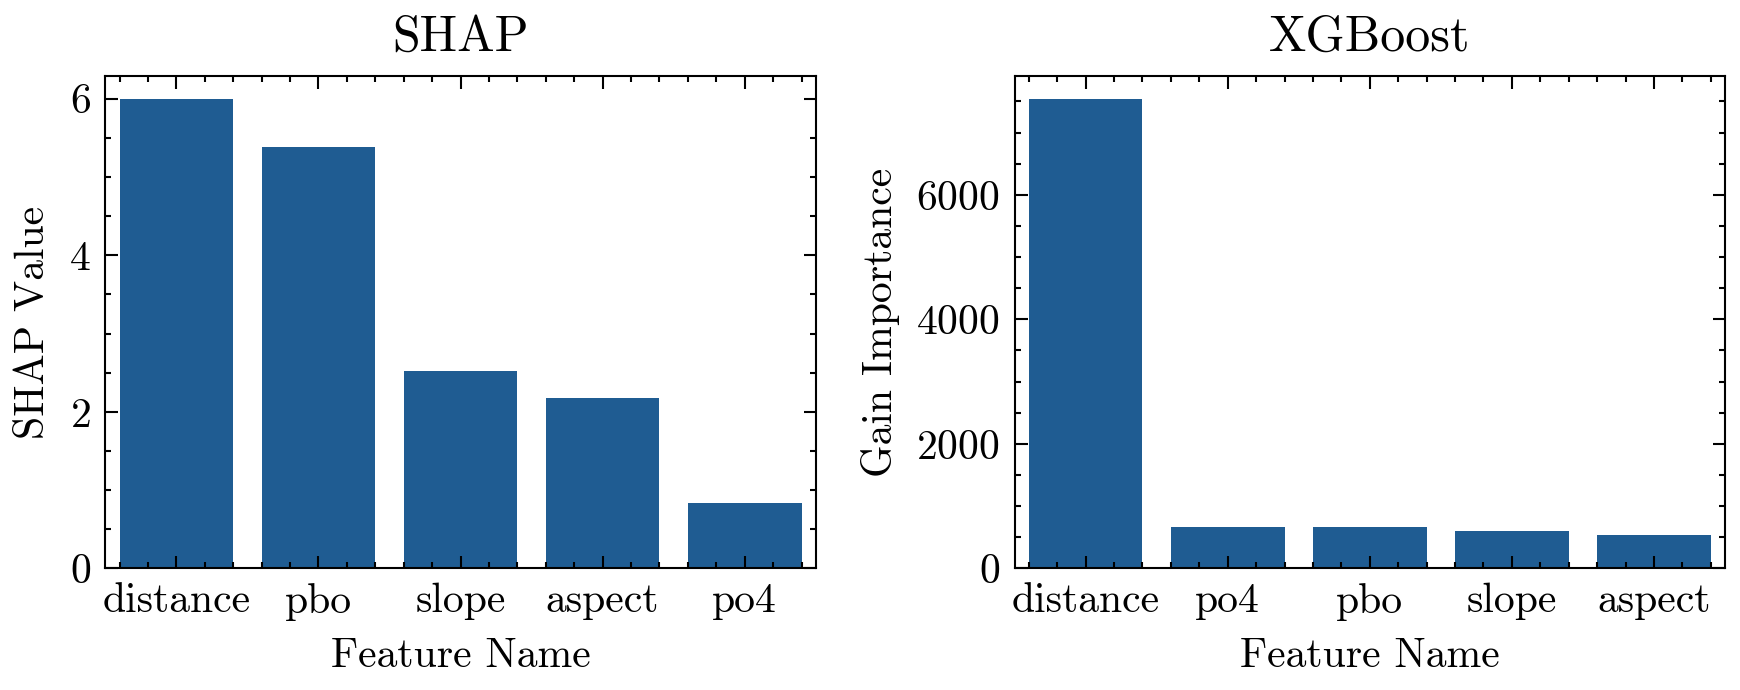

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))

sns.barplot(shap_abs_mean, ax=ax[0])
ax[0].set_title("SHAP")
ax[0].set_xlabel("Feature Name")
ax[0].set_ylabel("SHAP Value")

sns.barplot(xgb_importance, ax=ax[1])
ax[1].set_title("XGBoost")
ax[1].set_xlabel("Feature Name")
ax[1].set_ylabel("Gain Importance")

fig.tight_layout()

fig.savefig("FIG-13.jpg")
fig.savefig("FIG-13.pdf")
plt.show()

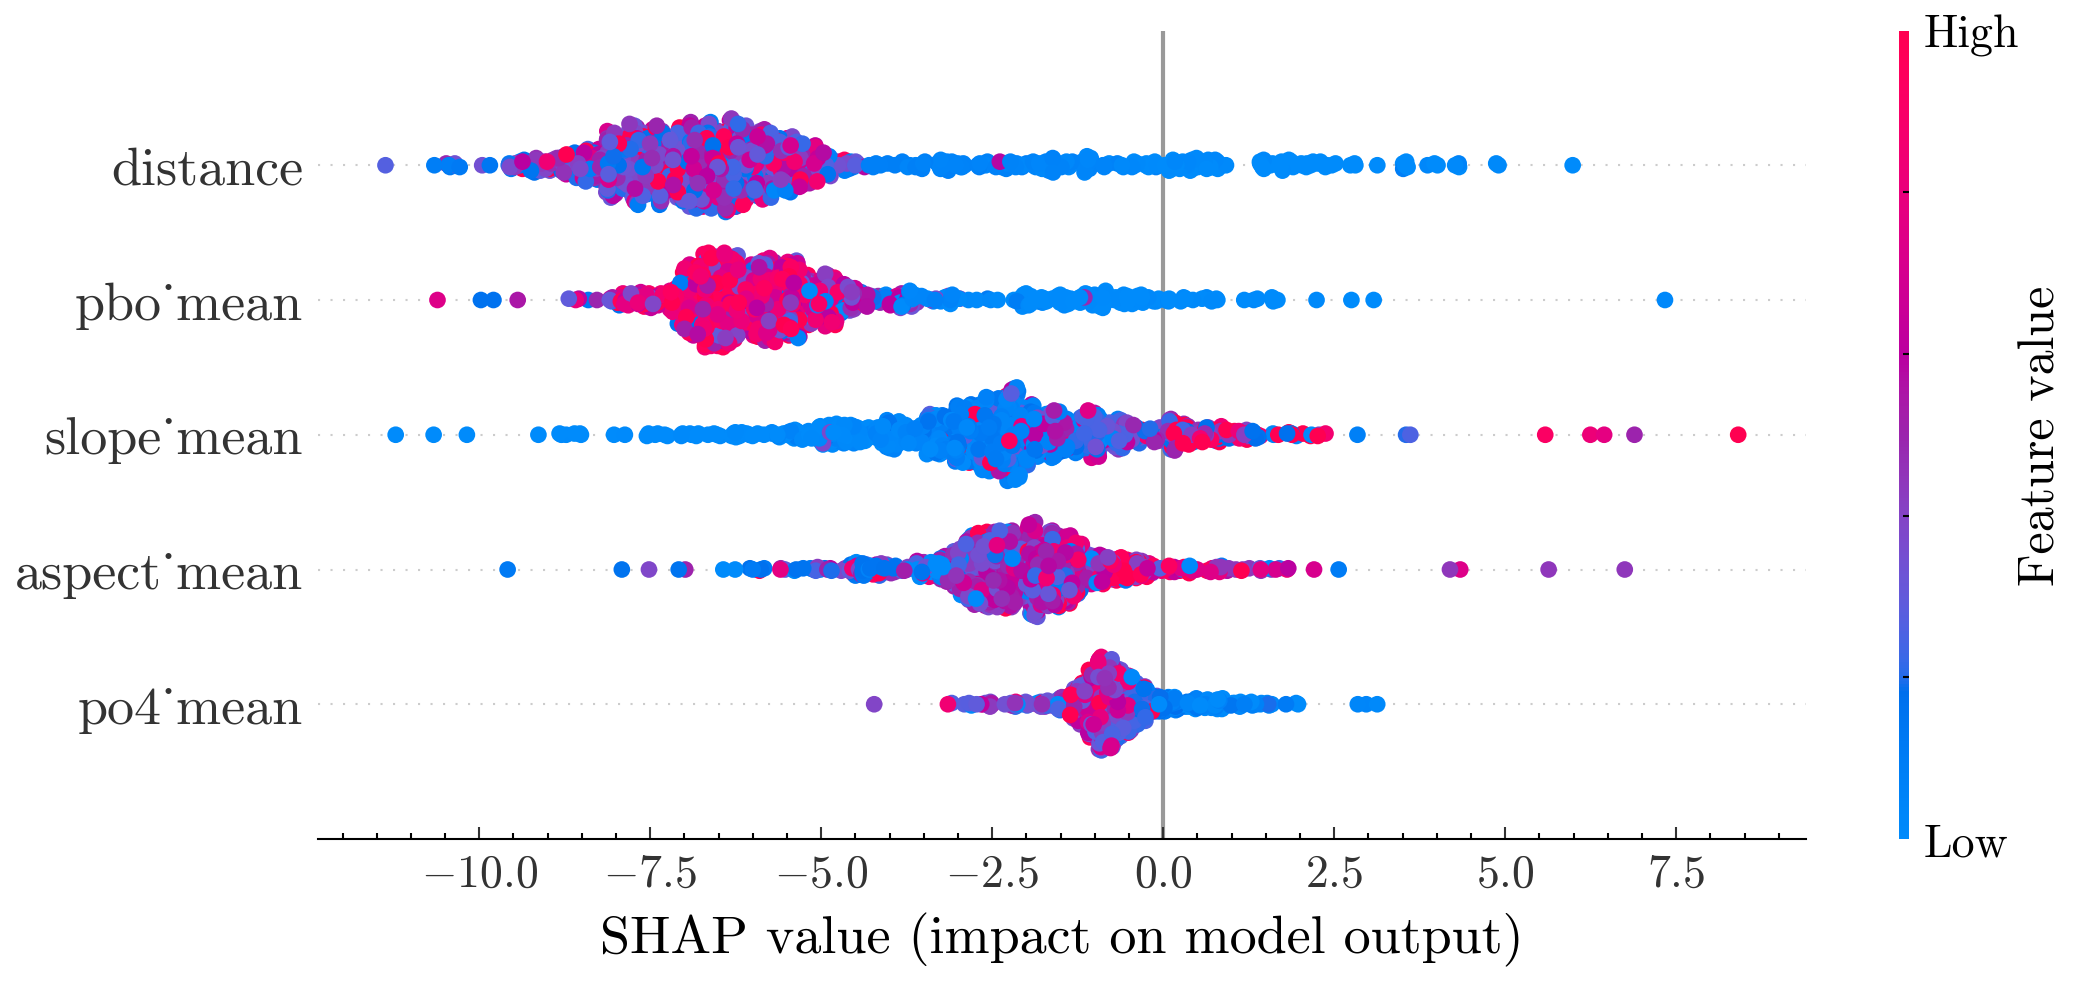

In [18]:
shap.plots.beeswarm(shap_values)